In [1]:
import numpy as np
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns

In [2]:
file_dir = os.getcwd()
data_dir = os.path.join(file_dir, 'datasets')

In [3]:
# cds_csv_path = os.path.join(data_dir, 'cds.csv')
# cds_data = pd.read_csv(cds_csv_path, index_col='Date')

In [4]:
cds_DF = pd.read_csv("datasets/cds.csv", parse_dates=['Date'])
cds_DF.head()

,Date,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
0,2015-01-01,A,Agilent Technologies Inc,14.850,25.05,39.055,73.715,86.30,111.305,125.905,144.300,158.600,168.195
1,2015-01-02,A,Agilent Technologies Inc,14.855,25.15,39.160,73.600,86.40,111.510,126.100,144.375,158.775,168.375
2,2015-01-05,A,Agilent Technologies Inc,13.455,24.96,39.310,70.200,88.26,111.970,125.060,143.165,157.385,166.825
3,2015-01-06,A,Agilent Technologies Inc,15.535,24.88,39.300,72.680,91.10,116.610,130.890,150.365,165.655,175.885
4,2015-01-07,A,Agilent Technologies Inc,15.215,25.50,40.270,73.880,92.50,117.780,131.940,151.145,166.215,176.295


In [5]:
#load all used ticker names in a list.
with open('datasets/tickers.txt', 'r') as ticks:
    tickers = ticks.read().split('\n')[:-1]

In [6]:
#create a dictionary with ticker names and corresponding dataframe created by create_correct_dataframe()
ticks_DF_dict = {}
for tick in cds_DF.groupby('Ticker').size()[cds_DF.groupby('Ticker').size() >= 1747].index:
    if len(cds_DF[cds_DF['Ticker'] == tick]['PX1'].unique()) > 1000:
        ticks_DF_dict[tick] = cds_DF[cds_DF['Ticker'] == tick].set_index("Date")

In [7]:
ticks_DF_dict

{'A':            Ticker                   Company      PX1      PX2      PX3  \
 Date                                                                     
 2015-01-01      A  Agilent Technologies Inc  14.8500  25.0500  39.0550   
 2015-01-02      A  Agilent Technologies Inc  14.8550  25.1500  39.1600   
 2015-01-05      A  Agilent Technologies Inc  13.4550  24.9600  39.3100   
 2015-01-06      A  Agilent Technologies Inc  15.5350  24.8800  39.3000   
 2015-01-07      A  Agilent Technologies Inc  15.2150  25.5000  40.2700   
 ...           ...                       ...      ...      ...      ...   
 2021-09-06      A  Agilent Technologies Inc  23.3313  28.2419  33.1765   
 2021-09-07      A  Agilent Technologies Inc  23.4577  28.3343  33.2722   
 2021-09-08      A  Agilent Technologies Inc  25.5318  30.8480  36.2270   
 2021-09-09      A  Agilent Technologies Inc  23.7530  28.6880  33.6839   
 2021-09-10      A  Agilent Technologies Inc  25.0883  30.3039  35.5824   
 
                 P

In [94]:
cds_data.head()

,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,,,
2015-01-01,A,Agilent Technologies Inc,14.850,25.05,39.055,73.715,86.30,111.305,125.905,144.300,158.600,168.195
2015-01-02,A,Agilent Technologies Inc,14.855,25.15,39.160,73.600,86.40,111.510,126.100,144.375,158.775,168.375
2015-01-05,A,Agilent Technologies Inc,13.455,24.96,39.310,70.200,88.26,111.970,125.060,143.165,157.385,166.825
2015-01-06,A,Agilent Technologies Inc,15.535,24.88,39.300,72.680,91.10,116.610,130.890,150.365,165.655,175.885
2015-01-07,A,Agilent Technologies Inc,15.215,25.50,40.270,73.880,92.50,117.780,131.940,151.145,166.215,176.295


In [95]:
# def autocorrelation_plotter(dataset, ticker, lagmin=1, lagmax=50, squared=False):

#     tickerset = dataset[dataset['Ticker'] == ticker]
#     px_columns = [f'PX{i}' for i in range(1, 11)]

#     fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))
#     axes = axes.flatten()

#     # iterate over PX columns and plot ACF for each
#     for i, col in enumerate(px_columns):
#         price_col = tickerset[col]

#         if squared == True:
#             plot_acf(price_col**2, lags=np.arange(lagmin, lagmax), ax=axes[i], title=f"Autocorr: {col}", auto_ylims=True, color='firebrick')
#         else:
#             plot_acf(price_col, lags=np.arange(lagmin, lagmax), ax=axes[i], title=f"Autocorr: {col}", auto_ylims=True, color='firebrick')
        
#         axes[i].set_xlim(lagmin, lagmax)
#         axes[i].set_xlabel("Lags")
#         axes[i].set_ylabel("Autocorrelation")
    
#     plt.tight_layout()
#     plt.suptitle(f"Autocorrelation of CDS Prices for Ticker: {ticker}", fontsize=14, y=1.02)
#     plt.show()

In [13]:
def autocorrelation_plotter(dataset, ticker, lagmin=1, lagmax=50, squared=False):

    px_columns = [f'PX{i}' for i in range(1, 11)]

    # if ticker not in dataset:
    #     print(f"Ticker '{ticker}' not found in the dataset.")
    #     return

    tickerset = dataset[ticker]

    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))
    axes = axes.flatten()

    # iterate over PX columns and plot ACF for each
    for i, col in enumerate(px_columns):
        if col not in tickerset.columns:
            print(f"Column '{col}' not found for ticker '{ticker}'.")
            continue

        price_col = tickerset[col].dropna()

        if not price_col.empty:
            if squared:
                plot_acf(price_col**2, lags=np.arange(lagmin, lagmax), ax=axes[i], title=f"Autocorr: {col}", auto_ylims=True, color='firebrick')
            else:
                plot_acf(price_col, lags=np.arange(lagmin, lagmax), ax=axes[i], title=f"Autocorr: {col}", auto_ylims=True, color='firebrick')

            axes[i].set_xlim(lagmin, lagmax)
            axes[i].set_xlabel("Lags")
            axes[i].set_ylabel("Autocorrelation")
        else:
            axes[i].set_title(f"Autocorr: {col} (No Data)")

    plt.tight_layout()
    plt.suptitle(f"Autocorrelation of CDS Prices for Ticker: {ticker}", fontsize=14, y=1.02)
    plt.show()

In [8]:
def calculate_log_returns(dataset):
    
    px_columns = [f'PX{i}' for i in range(1, 11)]
    returns_dict = {}

    for ticker, df in dataset.items():
        returns_df = df.copy()
        for col in px_columns:
            # apply log returns transformation for each column
            returns_df[col] = (np.log(df[col]) - np.log(df[col].shift(1))) * 100
        returns_dict[ticker] = returns_df.dropna()

    return returns_dict

In [9]:
cds_returns_dict = calculate_log_returns(ticks_DF_dict)

In [12]:
cds_returns_dict['AAPL']['PX1'].mean()

0.004749931147952714

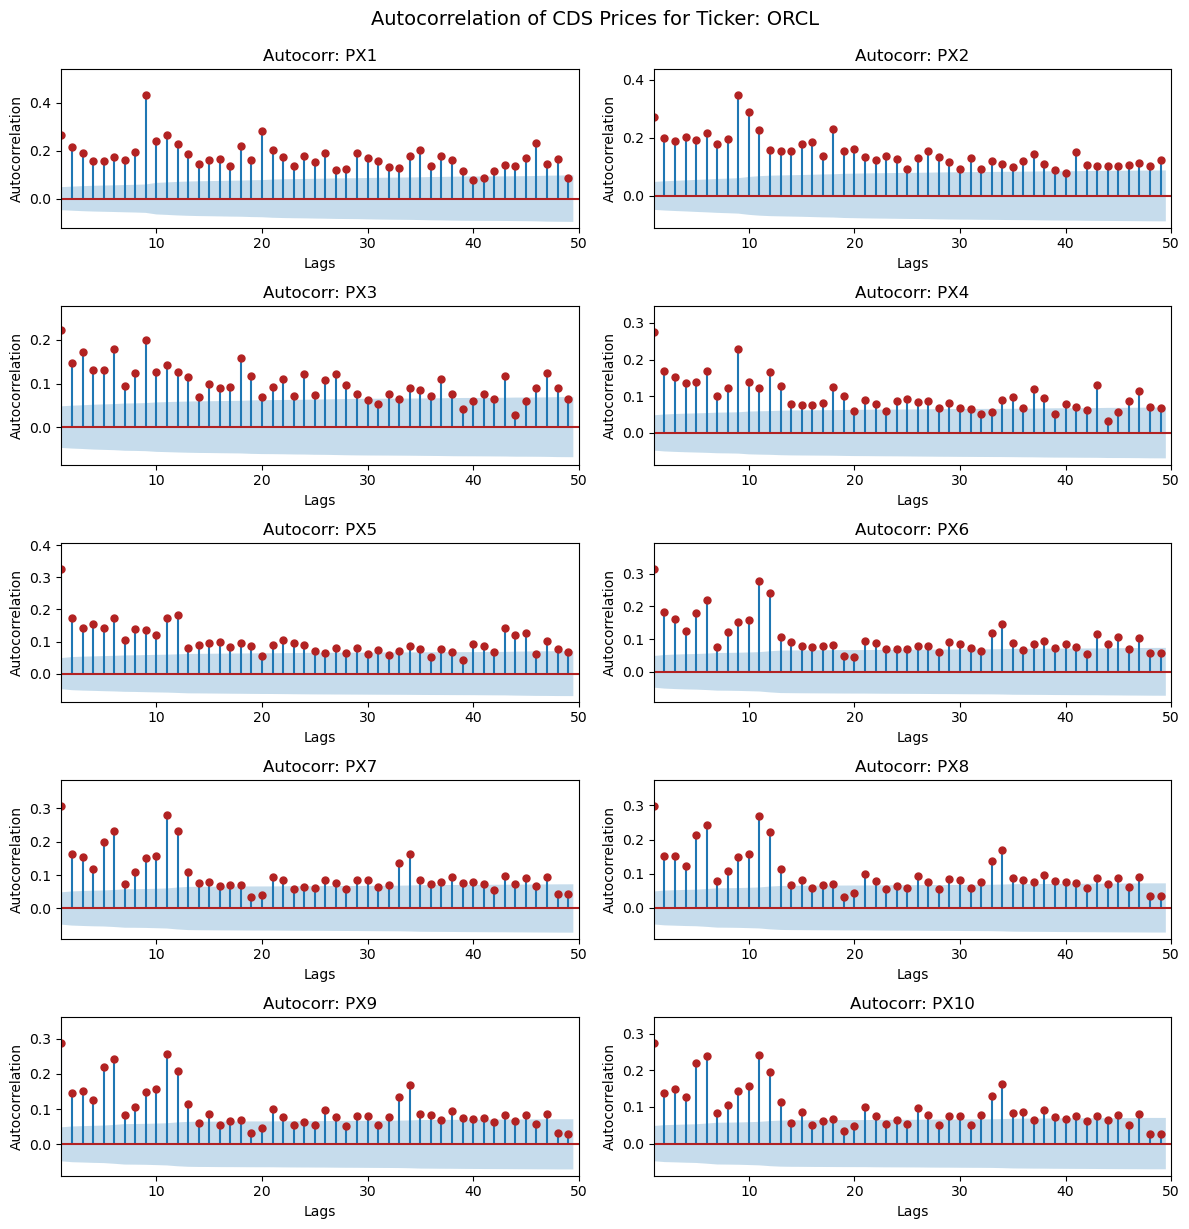

In [18]:
autocorrelation_plotter(cds_returns_dict, 'ORCL', squared=True)

In [97]:
# def calculate_log_returns(dataset):
    
#     px_columns = [f'PX{i}' for i in range(1, 11)]
#     returns_df = dataset.copy()
    
#     # group by ticker and apply log returns transformation
#     for col in px_columns:
#         returns_df[col] = dataset.groupby('Ticker')[col].transform(lambda price: (np.log(price/100) - np.log((price/100).shift(1)))*100)
    
#     return returns_df

In [98]:
# def calculate_first_diffs(dataset):
    
#     px_columns = [f'PX{i}' for i in range(1, 11)]
#     returns_df = dataset.copy()
    
#     # group by ticker and apply log returns transformation
#     for col in px_columns:
#         # divide by 100 because spreads are in basis points (% * 100)
#         returns_df[col] = dataset.groupby('Ticker')[col].transform(lambda price: price/100 - price.shift(1)/100)
    
#     return returns_df

In [99]:
# cds_returns = calculate_log_returns(cds_data)
# cds_returns = cds_returns.dropna()

# cds_returns.head()

,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,,,
2015-01-02,A,Agilent Technologies Inc,0.033664,0.398407,0.268491,-0.156128,0.115808,0.184009,0.154759,0.051962,0.110280,0.106961
2015-01-05,A,Agilent Technologies Inc,-9.898572,-0.758335,0.382312,-4.729671,2.129933,0.411671,-0.828162,-0.841627,-0.879307,-0.924828
2015-01-06,A,Agilent Technologies Inc,14.374476,-0.321028,-0.025442,3.471793,3.167080,4.060406,4.556365,4.906786,5.121228,5.288501
2015-01-07,A,Agilent Technologies Inc,-2.081376,2.461418,2.438226,1.637591,1.525084,0.998344,0.799000,0.517397,0.337482,0.232836
2015-01-08,A,Agilent Technologies Inc,-3.002227,2.325686,0.865378,-0.325380,0.625069,-0.989769,-1.889808,-1.762101,-1.729517,-1.727880


In [100]:
# cds_diffs = calculate_first_diffs(cds_data)
# cds_diffs = cds_diffs.dropna()

# cds_diffs.head()

,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,,,
2015-01-02,A,Agilent Technologies Inc,0.00005,0.0010,0.00105,-0.00115,0.0010,0.00205,0.00195,0.00075,0.00175,0.0018
2015-01-05,A,Agilent Technologies Inc,-0.01400,-0.0019,0.00150,-0.03400,0.0186,0.00460,-0.01040,-0.01210,-0.01390,-0.0155
2015-01-06,A,Agilent Technologies Inc,0.02080,-0.0008,-0.00010,0.02480,0.0284,0.04640,0.05830,0.07200,0.08270,0.0906
2015-01-07,A,Agilent Technologies Inc,-0.00320,0.0062,0.00970,0.01200,0.0140,0.01170,0.01050,0.00780,0.00560,0.0041
2015-01-08,A,Agilent Technologies Inc,-0.00450,0.0060,0.00350,-0.00240,0.0058,-0.01160,-0.02470,-0.02640,-0.02850,-0.0302


In [25]:
def split_train_test(cds_returns, split_date='2020-01-01'):
    train_set = {}
    test_set = {}

    for ticker, df in cds_returns.items():
        train_set[ticker] = df[df.index < split_date]
        test_set[ticker] = df[df.index >= split_date]
    
    return train_set, test_set

In [26]:
cds_returns_train, cds_returns_test = split_train_test(cds_returns_dict)

We can see that a GARCH model is appropriate here

Imported Parallel and delayed otherwise this code would take excessively long to run (days)

In [19]:
from joblib import Parallel, delayed

def fit_garch(data, p, q):
    model = arch_model(data, p=p, q=q, mean='Zero', rescale=True).fit(disp='off')
    return p, q, model.aic

In [20]:
def AIC_picker(dataset, max_p=3, max_q=3):
    px_columns = [f'PX{i}' for i in range(1, 11)]    
    results = {}

    # Iterate over tickers (keys in dataset dictionary)
    for ticker, df in dataset.items():
        results[ticker] = {}
        
        for col in px_columns:
            if col in df.columns:
                subset = df[col].dropna()
                if subset.empty:
                    results[ticker][col] = {'best_p': None, 'best_q': None, 'AIC': None}
                    continue
                
                # Parallel fitting of GARCH models
                fit_results = Parallel(n_jobs=-1)(delayed(fit_garch)(subset, p, q) for p in range(1, max_p + 1) for q in range(1, max_q + 1))
                
                # Initialize with GARCH(1,1)
                best_aic = fit_garch(subset, p=1, q=1)[-1]
                best_order = (1, 1)

                for p, q, aic in fit_results:
                    if aic < best_aic:  # Minimize AIC
                        best_aic = aic
                        best_order = (p, q)

                results[ticker][col] = {'best_p': best_order[0], 'best_q': best_order[1], 'AIC': best_aic}
            else:
                results[ticker][col] = {'best_p': None, 'best_q': None, 'AIC': None}
    
    return results

In [109]:
# from joblib import Parallel, delayed

# def fit_garch(data, p, q):

#     model = arch_model(data, p=p, q=q, mean='Zero', rescale=True).fit(disp='off')

#     return p, q, model.aic

In [110]:
# def AIC_picker(dataset, max_p=3, max_q=3):
    
#     px_columns = [f'PX{i}' for i in range(1, 11)]    
#     tickers = dataset['Ticker'].unique()
#     results = {}

#     for col in px_columns:
#         results[col] = {}

#         for ticker in tickers:
#             subset = dataset[dataset['Ticker'] == ticker][col].dropna()

#             fit_results = Parallel(n_jobs=-1)(delayed(fit_garch)(subset, p, q) for p in range(1, max_p + 1) for q in range(1, max_q + 1))

#             best_aic = fit_garch(subset, p=1, q=1)[-1]
#             best_order = (1,1)

#             for p, q, aic in fit_results:
#                 if aic > best_aic:
#                     best_aic = aic
#                     best_order = (p,q)

#             results[col][ticker] = {'best_p': best_order[0], 'best_q': best_order[1], 'AIC': best_aic}
    
#     return results

In [21]:
# cds_returns[cds_returns['PX1'] == max(cds_returns['PX1'])]

In [22]:
# cds_diffs[cds_diffs['PX1'] == max(cds_diffs['PX1'])]

In [28]:
aic_values_garch = AIC_picker(cds_returns_train)

c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.w

In [29]:
aic_values_garch

{'A': {'PX1': {'best_p': 1, 'best_q': 3, 'AIC': 7219.140026966437},
  'PX2': {'best_p': 1, 'best_q': 3, 'AIC': 7222.090312721238},
  'PX3': {'best_p': 2, 'best_q': 3, 'AIC': 7098.0821116322795},
  'PX4': {'best_p': 1, 'best_q': 3, 'AIC': 7114.638367185616},
  'PX5': {'best_p': 1, 'best_q': 3, 'AIC': 6939.467689402365},
  'PX6': {'best_p': 1, 'best_q': 3, 'AIC': 6768.271950867902},
  'PX7': {'best_p': 1, 'best_q': 3, 'AIC': 6683.528822193097},
  'PX8': {'best_p': 1, 'best_q': 3, 'AIC': 6606.69507510234},
  'PX9': {'best_p': 1, 'best_q': 3, 'AIC': 6550.403438098523},
  'PX10': {'best_p': 1, 'best_q': 3, 'AIC': 6503.528391718102}},
 'AALLN': {'PX1': {'best_p': 3, 'best_q': 3, 'AIC': 8720.469186320657},
  'PX2': {'best_p': 3, 'best_q': 3, 'AIC': 8291.418226545928},
  'PX3': {'best_p': 1, 'best_q': 1, 'AIC': 7806.31408033992},
  'PX4': {'best_p': 1, 'best_q': 1, 'AIC': 7216.828267640403},
  'PX5': {'best_p': 1, 'best_q': 1, 'AIC': 6761.480305716535},
  'PX6': {'best_p': 1, 'best_q': 3, 'AIC

In [38]:
# Parameters
num_sims = 1000

# Forecast 1-day returns for the test set using fitted GARCH parameters and actual observed test data
def forecast_test_returns(train_set, test_set, aic_results, num_simulations=num_sims, column='PX1'):
    forecasts = {}

    for ticker in test_set.keys():
        print(f"Processing {ticker} for column {column}...")
        train_df = train_set[ticker]
        test_df = test_set[ticker]

        if column in train_df.columns and column in test_df.columns:
            # retrieve best GARCH(p, q) orders
            best_p = aic_results.get(ticker, {}).get(column, {}).get('best_p', 1)
            best_q = aic_results.get(ticker, {}).get(column, {}).get('best_q', 1)

            if not best_p or not best_q:
                print(f"Skipping {ticker} as no valid GARCH parameters found.")
                forecasts[ticker] = None
                continue

            # fit GARCH on the train set
            train_returns = train_df[column].dropna()
            model = arch_model(train_returns, vol='Garch', p=best_p, q=best_q, mean='Zero')
            model_fit = model.fit(disp='off')

            forecasts[ticker] = []
            rolling_volatility = np.sqrt(model_fit.forecast(horizon=1).variance.values[-1, -1])
            previous_return = train_returns.iloc[-1]

            # iteratively forecast 1-day ahead returns for the test set using observed data
            for t in range(len(test_df)):
                omega = model_fit.params['omega']
                alpha = model_fit.params['alpha[1]']
                beta = model_fit.params['beta[1]']

                observed_return = test_df[column].iloc[t-1] if t > 0 else previous_return
                observed_squared = observed_return**2

                gjr_forecast = omega + alpha * observed_squared + beta * rolling_volatility**2
                rolling_volatility = np.sqrt(gjr_forecast)

                # Monte Carlo simulation for 1-day returns
                simulated_returns = rolling_volatility * np.random.randn(num_simulations)
                mean_forecast_return = simulated_returns.mean()
                forecasts[ticker].append(mean_forecast_return)

                previous_return = test_df[column].iloc[t]
        else:
            forecasts[ticker] = None

    return forecasts

In [42]:
forecasts_ret = forecast_test_returns(cds_returns_train, cds_returns_test, aic_values_garch, num_simulations=10, column='PX1')

Processing A for column PX1...
Processing AALLN for column PX1...
Processing AAPL for column PX1...
Processing ABC for column PX1...
Processing ABESM for column PX1...
Processing ABIBB for column PX1...
Processing ABT for column PX1...
Processing ABXCN for column PX1...
Processing ACAFP for column PX1...
Processing ACEIM for column PX1...
Processing ACFP for column PX1...
Processing ADENVX for column PX1...
Processing ADM for column PX1...
Processing ADNA for column PX1...
Processing ADP for column PX1...
Processing ADSGR for column PX1...
Processing AEGON for column PX1...
Processing AES for column PX1...
Processing AET for column PX1...
Processing AFG for column PX1...
Processing AGSBB for column PX1...
Processing AIFP for column PX1...
Processing AIG for column PX1...
Processing AIRFP for column PX1...
Processing AKZANA for column PX1...
Processing ALL for column PX1...
Processing ALLRNV for column PX1...
Processing ALLY for column PX1...
Processing ALOFP for column PX1...
Processin

c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Processing COF for column PX1...
Processing COFP for column PX1...
Processing COMQAT for column PX1...
Processing CONGR for column PX1...
Processing COP for column PX1...
Processing COST for column PX1...
Processing COXENT for column PX1...
Processing CPB for column PX1...
Processing CPGLN for column PX1...
Processing CPT for column PX1...
Processing CS for column PX1...
Processing CSCO for column PX1...
Processing CSX for column PX1...
Processing CTVA for column PX1...
Processing CVS for column PX1...
Processing CVX for column PX1...
Processing CXGD for column PX1...
Processing D for column PX1...
Processing DAIGR for column PX1...
Processing DAIWA for column PX1...
Processing DAL for column PX1...
Processing DANBNK for column PX1...
Processing DB for column PX1...
Processing DBOERS for column PX1...
Processing DE for column PX1...
Processing DEPFA for column PX1...
Processing DEVOBA for column PX1...
Processing DGELN for column PX1...
Processing DGFP for column PX1...
Processing DGX 

c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Processing ETN for column PX1...
Processing ETR for column PX1...
Processing EVKGR for column PX1...
Processing EWE for column PX1...
Processing EXPE for column PX1...
Processing F for column PX1...
Processing FABUH for column PX1...
Processing FCAIM for column PX1...
Processing FDX for column PX1...
Processing FFHCN for column PX1...
Processing FREGR for column PX1...
Processing FRFP for column PX1...
Processing FRT for column PX1...
Processing FTI for column PX1...


c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Processing FUMVFH for column PX1...
Processing GALPPL for column PX1...
Processing GAZPRU for column PX1...
Processing GD for column PX1...
Processing GE for column PX1...
Processing GFCFP for column PX1...
Processing GIS for column PX1...
Processing GLW for column PX1...
Processing GM for column PX1...
Processing GMGAU for column PX1...
Processing GMT for column PX1...
Processing GP for column PX1...
Processing GS for column PX1...
Processing GSK for column PX1...
Processing GT for column PX1...
Processing HAL for column PX1...
Processing HAS for column PX1...
Processing HCOB for column PX1...
Processing HD for column PX1...
Processing HEIANA for column PX1...
Processing HEIGR for column PX1...
Processing HENKEL for column PX1...
Processing HES for column PX1...
Processing HESLAN for column PX1...
Processing HIG for column PX1...
Processing HMSOLN for column PX1...
Processing HNDA for column PX1...
Processing HOFP for column PX1...
Processing HON for column PX1...
Processing HOTGR for

c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Processing MMM for column PX1...
Processing MMP for column PX1...
Processing MO for column PX1...
Processing MONTE for column PX1...
Processing MOS for column PX1...
Processing MQGAU for column PX1...
Processing MRK for column PX1...
Processing MRKGR for column PX1...
Processing MRO for column PX1...
Processing MS for column PX1...
Processing MSFT for column PX1...
Processing MSI for column PX1...
Processing MTNA for column PX1...
Processing MUBAUH for column PX1...
Processing MUV2.DE for column PX1...
Processing MWDP for column PX1...
Processing NAB for column PX1...
Processing NBL for column PX1...
Processing NDASS for column PX1...
Processing NDB for column PX1...
Processing NEE for column PX1...
Processing NEM for column PX1...
Processing NESNVX for column PX1...
Processing NGGLN for column PX1...


c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Processing NKE for column PX1...
Processing NNGRNV for column PX1...
Processing NOC for column PX1...
Processing NOKIA for column PX1...
Processing NOMURA for column PX1...
Processing NOVBNC for column PX1...
Processing NOVNVX for column PX1...
Processing NRG for column PX1...
Processing NRUC for column PX1...
Processing NSANY for column PX1...
Processing NSC for column PX1...
Processing NTGYSM for column PX1...
Processing NUE for column PX1...
Processing NVFVES for column PX1...
Processing NVR for column PX1...
Processing NWG for column PX1...
Processing NWIDE for column PX1...
Processing OC for column PX1...
Processing ODGR for column PX1...
Processing OKE for column PX1...
Processing OMC for column PX1...
Processing ORAFP for column PX1...
Processing ORCL for column PX1...
Processing ORIX for column PX1...
Processing ORSTED for column PX1...
Processing PAA for column PX1...
Processing PEAK for column PX1...
Processing PEMEX for column PX1...
Processing PEP for column PX1...
Processi

c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Processing SANSCF for column PX1...
Processing SANTAN for column PX1...
Processing SANUK for column PX1...
Processing SANUSA for column PX1...
Processing SAPSJ for column PX1...
Processing SBERRU for column PX1...
Processing SBIIN for column PX1...
Processing SCANIA for column PX1...


c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Processing SCBGER for column PX1...
Processing SCBNOR for column PX1...
Processing SCMNVX for column PX1...
Processing SCOR for column PX1...
Processing SDFGR for column PX1...
Processing SEB for column PX1...
Processing SEE for column PX1...
Processing SESGFP for column PX1...
Processing SFD for column PX1...
Processing SFRFP for column PX1...
Processing SGOFP for column PX1...
Processing SGTOPT for column PX1...
Processing SHBASS for column PX1...
Processing SHIMAO for column PX1...
Processing SHNHAN for column PX1...
Processing SHW for column PX1...
Processing SIBNEF for column PX1...
Processing SIEGR for column PX1...
Processing SJNKI for column PX1...
Processing SKENER for column PX1...
Processing SKM for column PX1...
Processing SLB for column PX1...
Processing SLG for column PX1...
Processing SMINLN for column PX1...
Processing SO for column PX1...
Processing SOCGEN for column PX1...
Processing SOFTBK for column PX1...
Processing SOLBBB for column PX1...
Processing SPGI for colu

c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Processing SYY for column PX1...
Processing SZUGR for column PX1...
Processing T for column PX1...
Processing TAP for column PX1...
Processing TCKBCN for column PX1...
Processing TCN for column PX1...
Processing TD for column PX1...
Processing TDCDC for column PX1...
Processing TELEFO for column PX1...
Processing TELIAS for column PX1...
Processing TELNO for column PX1...
Processing TELVIS for column PX1...
Processing TEVA for column PX1...
Processing TGT for column PX1...
Processing TITIM for column PX1...
Processing TJX for column PX1...
Processing TKAAV for column PX1...
Processing TKAGR for column PX1...
Processing TLSAU for column PX1...
Processing TOTAL for column PX1...
Processing TOYOTA for column PX1...
Processing TRICN for column PX1...
Processing TRV for column PX1...
Processing TSCOLN for column PX1...
Processing TSN for column PX1...
Processing TT for column PX1...
Processing TTEFP for column PX1...
Processing TTMTIN for column PX1...
Processing TXN for column PX1...
Proce

c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Processing VLO for column PX1...
Processing VLVY for column PX1...
Processing VMC for column PX1...
Processing VOD for column PX1...
Processing VW for column PX1...
Processing VZ for column PX1...
Processing WEC for column PX1...
Processing WELL for column PX1...
Processing WESAU for column PX1...
Processing WFC for column PX1...
Processing WHR for column PX1...
Processing WKLNA for column PX1...
Processing WM for column PX1...
Processing WMB for column PX1...
Processing WMT for column PX1...
Processing WOORIB for column PX1...
Processing WPLAU for column PX1...
Processing WSTP for column PX1...
Processing WU for column PX1...
Processing WY for column PX1...
Processing XL for column PX1...
Processing XOM for column PX1...


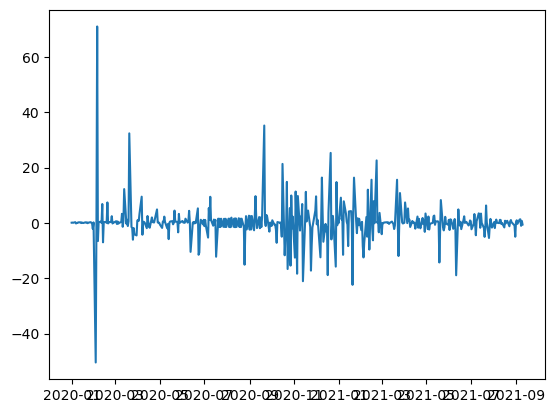

In [48]:
# plt.plot(forecasts_ret['AAPL'])
plt.plot(cds_returns_test['AAPL']['PX1'])

In [123]:
# def ten_day_price_forecast(dataset, model_results, K=10, MC=10000, dist='Normal', n_jobs=-1):

#     def simulate_cumulative_returns(subset, p_opt, q_opt, dist):

#         # fit GARCH
#         model = arch_model(subset, vol='Garch', p=p_opt, q=q_opt, mean='Zero', rescale=True)
#         result = model.fit(disp="off")
        
#         # 1-day ahead var forecast
#         forecast = result.forecast(horizon=1)
#         one_day_ahead_variance = forecast.variance.iloc[-1, 0]

#         # GARCH params
#         omega = result.params['omega']
#         alpha = result.params['alpha[1]']
#         beta = result.params['beta[1]']

#         # Monte Carlo simulation
#         sim_cumulative_returns = np.zeros((MC, K))
#         if dist == 'Normal':
#             sim_shocks = np.random.randn(K, MC)
#         else:
#             d1 = result.distribution.df
#             sim_shocks = np.sqrt((d1 - 2) / d1) * stats.t.rvs(d1, size=(K, MC))

#         cond_variance = np.zeros((K, MC))
#         cond_variance[0, :] = one_day_ahead_variance
        
#         for k in range(1, K):
#             cond_variance[k, :] = omega + alpha * (sim_shocks[k-1, :] ** 2) + beta * cond_variance[k-1, :]

#         sim_returns = np.sqrt(cond_variance) * sim_shocks
#         sim_cumulative_returns = np.cumsum(sim_returns, axis=0)

#         return sim_cumulative_returns

#     # parallel Execution
#     px_columns = [f'PX{i}' for i in range(1, 11)]
#     tickers = dataset['Ticker'].unique()
#     forecast_results = {}

#     for col in px_columns:
#         forecast_results[col] = {}

#         def process_ticker(ticker):
#             subset = dataset[dataset['Ticker'] == ticker][col].dropna()

#             if col not in model_results or ticker not in model_results[col]:
#                 return ticker, None
#             p_opt = model_results[col][ticker]['best_p']
#             q_opt = model_results[col][ticker]['best_q']

#             # sim cumulative returns
#             sim_cumulative_returns = simulate_cumulative_returns(subset, p_opt, q_opt, dist)
#             return ticker, sim_cumulative_returns

#         # parallel processing for all tickers
#         results = Parallel(n_jobs=n_jobs)(delayed(process_ticker)(ticker) for ticker in tickers)

#         for ticker, simulation_results in results:
#             if simulation_results is not None:
#                 forecast_results[col][ticker] = simulation_results

#     return forecast_results

In [127]:
def ten_day_price_forecast(dataset, model_results, K=10, MC=10000, dist='Normal', n_jobs=-1, mc_jobs=-1):

    def simulate_mc_batch(batch_size, shocks, omega, alpha, beta, one_day_variance, K):

        cond_variance = np.zeros((K, batch_size))
        cond_variance[0, :] = one_day_variance

        for k in range(1, K):
            cond_variance[k, :] = omega + alpha * (shocks[k-1, :] ** 2) + beta * cond_variance[k-1, :]

        sim_returns = np.sqrt(cond_variance) * shocks
        sim_cumulative_returns = np.cumsum(sim_returns, axis=0)
        return sim_cumulative_returns

    def simulate_cumulative_returns(subset, p_opt, q_opt, dist, MC, K):

        # fit GARCH
        model = arch_model(subset, vol='Garch', p=p_opt, q=q_opt, mean='Zero', rescale=True)
        result = model.fit(disp="off")
        
        # 1-day ahead variance forecast
        forecast = result.forecast(horizon=1)
        one_day_ahead_variance = forecast.variance.iloc[-1, 0]

        # GARCH params
        omega = result.params['omega']
        alpha = result.params['alpha[1]']
        beta = result.params['beta[1]']

        # Monte Carlo shocks
        batch_size = MC // 10  # Split into 10 batches
        total_batches = 10

        if dist == 'Normal':
            shocks = [np.random.randn(K, batch_size) for _ in range(total_batches)]
        else:
            d1 = result.distribution.df
            shocks = [np.sqrt((d1 - 2) / d1) * stats.t.rvs(d1, size=(K, batch_size)) for _ in range(total_batches)]

        # parallelize Monte Carlo batches
        mc_results = Parallel(n_jobs=mc_jobs)(delayed(simulate_mc_batch)(batch_size, shocks[i], omega, alpha, beta, one_day_ahead_variance, K) for i in range(total_batches))

        return np.hstack(mc_results)

    # parallel Execution
    px_columns = [f'PX{i}' for i in range(1, 11)]
    tickers = dataset['Ticker'].unique()
    forecast_results = {}

    for col in px_columns:
        forecast_results[col] = {}

        def process_ticker(ticker):
            subset = dataset[dataset['Ticker'] == ticker][col].dropna()

            p_opt = model_results[col][ticker]['best_p']
            q_opt = model_results[col][ticker]['best_q']

            # sim cumulative returns
            sim_cumulative_returns = simulate_cumulative_returns(subset, p_opt, q_opt, dist, MC, K)
            return ticker, sim_cumulative_returns

        # parallel processing for all tickers
        results = Parallel(n_jobs=n_jobs)(delayed(process_ticker)(ticker) for ticker in tickers)

        for ticker, simulation_results in results:
            if simulation_results is not None:
                forecast_results[col][ticker] = simulation_results

    return forecast_results

In [128]:
cds_returns_forecast_garch = ten_day_price_forecast(cds_returns, aic_values_garch)

 ...]

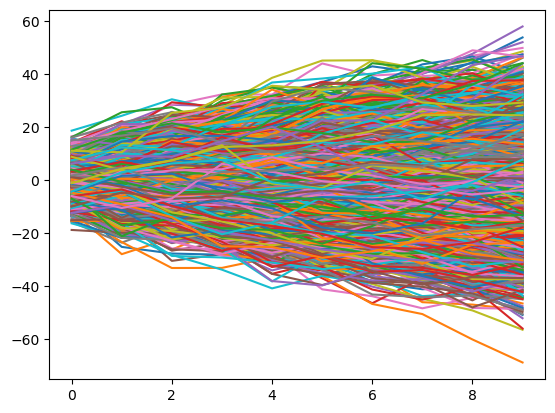

In [130]:
plt.plot(cds_returns_forecast_garch['PX1']['AAPL'])

In [147]:
def forecast_all_paths(cds_returns, returns_forecast):

    px_columns = [f'PX{i}' for i in range(1, 11)]
    tickers = cds_returns['Ticker'].unique()

    all_paths_forecast = {}

    for col in px_columns:
        all_paths_forecast[col] = {}

        for ticker in tickers:
            last_price = cds_returns[cds_returns['Ticker'] == ticker][col].dropna().iloc[-1]
            sim_cumulative_returns = returns_forecast[col][ticker]  # shape: (K, MC)

            # convert cum. returns to prices - * 10**4 because prices in bps 
            price_paths = last_price * np.exp(sim_cumulative_returns / 100)

            all_paths_forecast[col][ticker] = price_paths

    return all_paths_forecast

In [148]:
price_forecast_garch = forecast_all_paths(cds_returns, cds_returns_forecast_garch)

In [155]:
cds_prices_apple =  cds_data[cds_data['Ticker'] == 'AAPL']
cds_prices_apple = cds_prices_apple.drop(['Ticker', 'Company'], axis=1)
cds_prices_apple = cds_prices_apple / 100

In [156]:
cds_prices_apple

,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,
2015-01-01,0.083000,0.111000,0.129000,0.168000,0.236000,0.318000,0.366950,0.428000,0.476050,0.516000
2015-01-02,0.083000,0.111000,0.129000,0.168000,0.236000,0.318050,0.367050,0.428000,0.476050,0.516000
2015-01-05,0.095350,0.128000,0.148900,0.194150,0.272900,0.365200,0.418600,0.484550,0.535600,0.577700
2015-01-06,0.078200,0.104550,0.121450,0.158150,0.222250,0.301100,0.349050,0.409050,0.456700,0.496700
2015-01-07,0.078350,0.104750,0.121750,0.158600,0.223000,0.302200,0.350350,0.410650,0.458500,0.498600
...,...,...,...,...,...,...,...,...,...,...
2021-09-06,0.089743,0.113786,0.149022,0.197909,0.249750,0.301480,0.338160,0.361508,0.379590,0.394028
2021-09-07,0.090938,0.113503,0.149447,0.198661,0.250044,0.302151,0.339095,0.362367,0.380375,0.394716
2021-09-08,0.090012,0.112324,0.147874,0.196538,0.247329,0.298982,0.335697,0.358889,0.376874,0.391222


In [157]:
price_forecast_garch['PX1']['AAPL']

array([[-0.5617598 , -0.56139619, -0.56123048, ..., -0.56184895,
        -0.56168368, -0.56150625],
       [-0.56195436, -0.56127436, -0.56111228, ..., -0.56202211,
        -0.56199101, -0.56191454],
       [-0.5618854 , -0.56106566, -0.561431  , ..., -0.56160818,
        -0.56217003, -0.56210242],
       ...,
       [-0.56119858, -0.56142638, -0.56080772, ..., -0.56203326,
        -0.56312453, -0.56133944],
       [-0.56114412, -0.56150173, -0.56091822, ..., -0.56242699,
        -0.56314402, -0.56170769],
       [-0.56090267, -0.56156037, -0.56095181, ..., -0.56270315,
        -0.56312277, -0.56218742]])

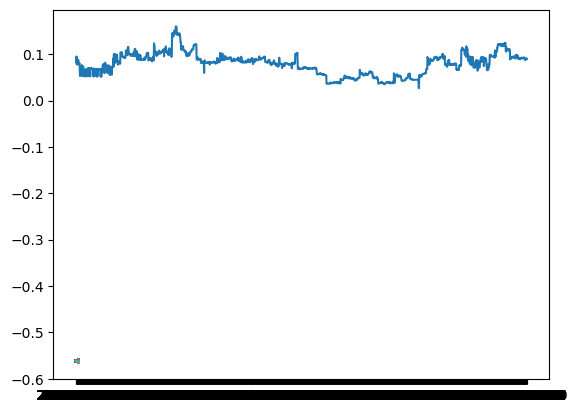

In [158]:
plt.plot(price_forecast_garch['PX1']['AAPL'])
plt.plot(cds_prices_apple['PX1'])